# ImbalanceMetrics (Classification): Usage
## Example 3: Advanced

## Dependencies
First, we load the required dependencies. Here we import classification_metrics from imbalance_metrics to evalute the result we get from the RandomForestClassifier. In addition, we use pandas for data handling, StratifiedKFold for crossvalidation and matplotlib to visualize the result.

In [1]:
## load dependencies
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import  roc_auc_score,  precision_recall_curve, average_precision_score, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from imbalance_metrics import classification_metrics as cm
import pandas as pd

## Data
After, we load our data. This dataset is taken from the KEEL repository.

In [2]:
## load data
df = pd.read_csv(
    'https://raw.githubusercontent.com/paobranco/ImbalanceMetrics/main/data/glass0.csv', skipinitialspace=True, header=None
)
df.head()

,0,1,2,3,4,5,6,7,8,9
0,1.515888,12.87795,3.43036,1.40066,73.2820,0.68931,8.04468,0.0,0.1224,0
1,1.517642,12.97770,3.53812,1.21127,73.0020,0.65205,8.52888,0.0,0.0000,0
2,1.522130,14.20795,3.82099,0.46976,71.7700,0.11178,9.57260,0.0,0.0000,0
3,1.522221,13.21045,3.77160,0.79076,71.9884,0.13041,10.24520,0.0,0.0000,0
4,1.517551,13.39000,3.65935,1.18880,72.7892,0.57132,8.27064,0.0,0.0561,0


In [3]:
df.describe()

,0,1,2,3,4,5,6,7,8,9
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518366,13.413409,2.684516,1.444895,72.655649,0.497235,8.960538,0.177563,0.042611,0.672897
std,0.003037,0.819794,1.442342,0.499361,0.778654,0.652188,1.426621,0.497925,0.092474,0.470255
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,0.000000
25%,1.516526,12.906213,2.113668,1.188800,72.279600,0.121095,8.238360,0.000000,0.000000,0.000000
50%,1.517688,13.303550,3.479750,1.358930,72.789200,0.555795,8.604200,0.000000,0.000000,1.000000
75%,1.519163,13.823913,3.600980,1.628570,73.097200,0.608580,9.177170,0.000000,0.056100,1.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,1.000000


In [4]:
# Assign x and y values from the dataframe
X = df.drop(columns=[9])
y = df[9]
y

0      0
1      0
2      0
3      0
4      0
      ..
209    1
210    1
211    1
212    1
213    1
Name: 9, Length: 214, dtype: int64

Here, we are converting categorical y values to numerical. For this experiment, we have converted negative to 0 and positive to 1.

## Model & Metrics
After, we train our model with data. In this example, we use the `RandomForestClassifier()` from sklearn. We are also using cross validation with 6 folds. After 6 folds, we get 'gmean score' and 'hscrors' for each folds along with 'y_probabilites' of all folds which we use to calculate 'Precision-Recall curve','Precision-Recall-Gain curve', 'Davis interpolation' and 'Manning interpolation'. After calculating all the metrics, we plot the data.

In [5]:
clf = RandomForestClassifier(random_state=42)


As mentioned earlier, we have used 6 folds cross validation. Here we have calculated gmeans and hscores on each fold and printed them afterward 6 folds.

In [6]:
# cross validation fold
cv = StratifiedKFold(n_splits=5)

# declaring lists to store the results in each fold to plot them
gmeans = []
hscores = []

y_probabilities = []
y_real = []

for train,test in cv.split(X, y) :
    #Train the model
    clf.fit(X.iloc[train], y.iloc[train])
    
    #Predictions
    pred = clf.predict(X.iloc[test])
    pred_proba = clf.predict_proba(X.iloc[test])
    

    y_real.append(y.iloc[test]) #Storing the real y values for calculating the precision-recall curve
    y_probabilities.append(pred_proba[:,0]) #Storing the predictions probabilities of 0 for calculating the precision-recall curve
    

    #Scores
    gmeans.append(cm.gmean_score(y_true=y[test], y_pred=pred))

print("gmean score: ",gmeans)


gmean score:  [0.8766258645533686, 0.8596023825918792, 0.8766258645533686, 0.8154904233293435, 0.7873359887517358]


After 5 folds, we also get the probabilites of each fold from the model. Using this we can now calculate 'Precision-Recall curve','Davis interpolation' and 'Manning interpolation'.

In [7]:

# Make concatenated numpy arrays.
y_real = np.concatenate(y_real)
y_probabilities = np.concatenate(y_probabilities)

#Calculate Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_real, y_probabilities,pos_label = 0)
pr_auc = auc(recall, precision)
pr_auc_ap = average_precision_score(y_real, y_probabilities) #Average precision recall from sklearn
print("Average precision score: ",pr_auc_ap)

lab = 'Overall AUC=%.4f' % (pr_auc)

#Calculate Davis interpolation
precision_davis, recall_davis, pr_auc_davis = cm.pr_davis(y_real, y_probabilities,True)
print("Average precision recall davis score: ",pr_auc_davis)

#Calculate Manning interpolation
recInv, decreasing_max_precision, pr_auc_manning = cm.pr_manning(y_real, y_probabilities,True)
print("Average precision recall manning score: ",pr_auc_davis)



Average precision score:  0.4764776400296415
Average precision recall davis score:  0.8576082701175363
Average precision recall manning score:  0.8576082701175363


## Plotting
Lastly, we are plotting the results we have gained earlier.

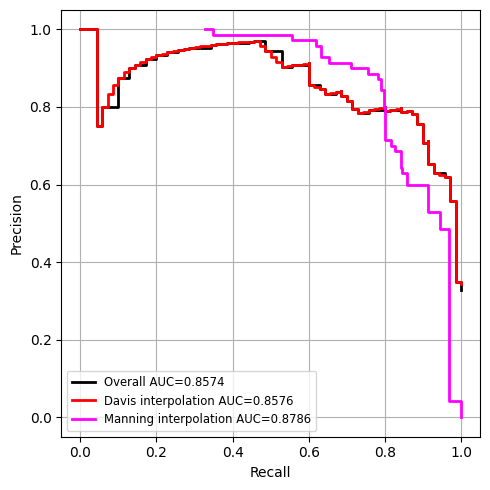

In [8]:

f, axes = plt.subplots(1, 1, figsize=(5, 5))
axes.grid(visible=True)
axes.step(recall, precision, label=lab, lw=2, color='black')
axes.step(recall_davis, precision_davis, label='Davis interpolation AUC=%.4f' % (pr_auc_davis), lw=2, color='red') #Davis interpolation
axes.step(recInv, decreasing_max_precision, label='Manning interpolation AUC=%.4f' % (pr_auc_manning), lw=2, color='fuchsia') #Manning interpolation
axes.set_xlabel('Recall')
axes.set_ylabel('Precision')
axes.legend(loc='lower left', fontsize='small')



f.tight_layout()


We can also perform above cross validation by using `cross_validate_auc()` function. The examples are given below.

In [9]:
# As auc() uses precision and recall, we set pr to True so the cross_validate_auc() calculates precision and recall and use them in auc() function.
cv_auc = cm.cross_validate_auc(clf,X,y,auc,5,pr = True)
print(cv_auc)

0.8573713896866004


In [10]:
cv_davis = cm.cross_validate_auc(clf,X,y,cm.pr_davis,5)
print(cv_davis)

0.8576082701175363


In [11]:
cv_manning = cm.cross_validate_auc(clf,X,y,cm.pr_manning,5)
print(cv_manning)

0.8786446518557852


## Conclusion

In this package, we have presented a set of evaluation metrics specifically designed for imbalanced domains. Our package, "ImbalanceMetrics", provides a comprehensive set of evaluation metrics to assess the performance of machine learning models trained on imbalanced datasets.

Our package includes several evaluation metrics that address the challenges of imbalanced domains. These metrics can provide a more accurate assessment of model performance than traditional metrics, which can be misleading in imbalanced domains.

To learn more about our package, please refer to the documentation, which includes detailed descriptions of all the available metrics and their usage.